# Preserving spatial derivatives with safeguards

In this example, which has been adpted from the ZFP evaluation at <https://computing.llnl.gov/projects/zfp/zfp-and-derivatives>, we compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the second derivative of the data, and apply safeguards to guarantee that spatial derivatives are preserved.

In [1]:
import humanize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
x = y = np.linspace(-1, 1, 1024)
Y, X = np.meshgrid(y, x, indexing="ij")

In [3]:
dx = float(x[1] - x[0])
dy = float(y[1] - y[0])
dy, dx

(0.0019550342130987275, 0.0019550342130987275)

In [4]:
# compute the Laplacian DU for a 2D field U using numpy.gradient
def compute_DU(U):
    return np.gradient(
        np.gradient(U, y, axis=0, edge_order=1), y, axis=0, edge_order=1
    ) + np.gradient(np.gradient(U, x, axis=1, edge_order=1), x, axis=1, edge_order=1)

In [5]:
def compute_corrections_percentage(my_U: np.ndarray, orig_U: np.ndarray) -> float:
    return np.mean(my_U != orig_U)

In [6]:
# plot the Laplacian DU for a 2D field my_U
def plot_DU(
    my_U,
    cr,
    ax,
    title,
    DU_eb_abs,
    transform=None,
    transform_symbol=None,
    my_DU=None,
    corr=None,
    my_U_it=None,
    cr_it=None,
):
    show_err = my_DU is None

    if my_DU is None:
        my_DU = compute_DU(my_U)

    DU = compute_DU(U)

    if transform is not None:
        with np.errstate(
            divide="ignore", over="ignore", under="ignore", invalid="ignore"
        ):
            DU = transform(DU)
            my_DU = transform(my_DU)

    vmin = np.nanmin(DU)
    vmax = np.nanmax(DU)

    err_U_inf = np.amax(np.abs(my_U - U))
    err_DU_inf = np.amax(np.abs(my_DU - DU))
    err_DU_fin_inf = np.nanmax(
        np.nan_to_num(
            np.abs(my_DU - DU),
            nan=np.nan,
            posinf=np.nan,
            neginf=np.nan,
        )
    )
    err_DU_2 = np.sqrt(np.mean(np.square(my_DU - DU)))
    err_DU_fin_2 = np.sqrt(
        np.nanmean(
            np.nan_to_num(
                np.square(my_DU - DU),
                nan=np.nan,
                posinf=np.nan,
                neginf=np.nan,
            )
        )
    )
    err_v = np.mean(~(np.abs(my_DU - DU) <= DU_eb_abs))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    if show_err:
        if my_U_it is not None:
            corr_it = (
                None if corr is None else compute_corrections_percentage(my_U_it, corr)
            )

        corr = None if corr is None else compute_corrections_percentage(my_U, corr)

        transform_start = "" if transform is None else f"{transform_symbol}("
        transform_end = "" if transform is None else ")"

        ax.set_title(
            f"{title}\n"
            + rf"$L_{{\infty}}(\hat{{u}})$={err_U_inf:.02}  "
            + rf"$L_{{\infty}}({transform_start}\Delta \hat{{u}}{transform_end})$={err_DU_inf:.02}"
            + ("" if np.isfinite(err_DU_inf) else f" ({err_DU_fin_inf:.02})")
            + "\n"
            + rf"$L_{{2}}({transform_start}\Delta \hat{{u}}{transform_end})$={err_DU_2:.02}"
            + ("" if np.isfinite(err_DU_2) else f" ({err_DU_fin_2:.02})")
            + "\n"
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                    + (
                        ""
                        if corr_it is None
                        else (
                            f" ({0 if corr == 0 else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + '%'})"
                        )
                    )
                )
            )
        )
    else:
        ax.set_title(f"{title}\n\n")

    # create a colourmap that includes the entire finite range of my_DU but
    #  assigns colours based on the range of DU to ensure consistent colours
    cx = np.linspace(
        (
            np.minimum(np.amin(np.nan_to_num(my_DU, nan=0, posinf=0, neginf=0)), vmin)
            - vmin
        )
        / (vmax - vmin),
        (
            np.maximum(vmax, np.amax(np.nan_to_num(my_DU, nan=0, posinf=0, neginf=0)))
            - vmin
        )
        / (vmax - vmin),
        256,
    )
    cmap = LinearSegmentedColormap.from_list("RdBu_r_ext", plt.get_cmap("RdBu_r")(cx))

    ax.fill_between(
        [0, 1],
        [1, 1],
        hatch="XX",
        edgecolor="magenta",
        facecolor="lavenderblush",
        transform=ax.transAxes,
        zorder=-13,
    )
    im = ax.imshow(my_DU, cmap=cmap, origin="lower", extent=(-1, 1, -1, 1), zorder=-12)

    ax.contour(
        X,
        Y,
        my_DU,
        levels=10,
        colors="lightgrey",
        vmin=vmin,
        vmax=vmax,
        alpha=0.25,
        zorder=-11,
    )

    ax.set_rasterization_zorder(-10)
    ax.set_aspect("equal")

    t = ax.text(
        0.95,
        0.95,
        (
            f"x {np.round(cr, 2)}"
            + ("" if cr_it is None else f" (x {np.round(cr_it, 2)})")
        )
        if show_err
        else humanize.naturalsize(U.nbytes, binary=True),
        ha="right",
        va="top",
        transform=ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.5, edgecolor="black"))

    cb = ax.get_figure().colorbar(im, cax=cax, orientation="vertical")

    if show_err:
        cb.ax.fill_between(
            cb.ax.get_xlim(),
            cb.ax.get_ylim()[0],
            np.amin(DU),
            hatch="xxx",
            ec="w",
            fc="none",
        )
        cb.ax.fill_between(
            cb.ax.get_xlim(),
            np.amax(DU),
            cb.ax.get_ylim()[1],
            hatch="xxx",
            ec="w",
            fc="none",
        )

## Example 1: $u(x, y) = {(x^2 + y^2)}^{3 \mathbin{/} 2} \mathbin{/} 9$

The Laplacian of $u$ is $\Delta u = \sqrt{x^2 + y^2}$.

We evaluate the Laplacian numerically on the original $u$ and the compressed $\hat{u}$s by twice applying the `np.gradient` function.

In [7]:
U = np.power(X**2 + Y**2, 3 / 2) / 9

In [8]:
# analytical solution on uncompressed
DU = np.sqrt(X**2 + Y**2)

In [9]:
# absolute error bound for error-bounded lossy compression
eb_abs = 1e-6

In [10]:
# compressed with ZFP
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

U_zfp_enc = zfp.encode(U)
U_zfp = zfp.decode(U_zfp_enc)
U_zfp_cr = U.nbytes / U_zfp_enc.nbytes

In [11]:
# compressed with SZ3
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

U_sz3_enc = sz3.encode(U)
U_sz3 = sz3.decode(U_sz3_enc)
U_sz3_cr = U.nbytes / U_sz3_enc.nbytes

In [12]:
# compressed with SPERR
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

U_sperr_enc = sperr.encode(U)
U_sperr = sperr.decode(U_sperr_enc)
U_sperr_cr = U.nbytes / U_sperr_enc.nbytes

In [13]:
# compressed to constant zero
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

U_zero_enc = zero.encode(U)
U_zero = zero.decode(U_zero_enc)

In [14]:
DU_eb_abs = 0.1

In [15]:
from numcodecs_safeguards import SafeguardsCodec

In [16]:
U_sg_qoi = dict()
U_sg_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_qoi = SafeguardsCodec(
        codec=codec,
        # numpy.gradient uses central differences on the inner points and
        #  forward/backward differences on the boundary
        # with constant spacing, central differences with edge boundaries are
        #  equivalent
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                (
                    finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing=c["dy"]) +
                    finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing=c["dx"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=1, after=1, boundary="edge"),
                    dict(axis=1, before=1, after=1, boundary="edge"),
                ],
                type="abs",
                eb=DU_eb_abs,
            ),
        ],
        fixed_constants=dict(dx=dx, dy=dy),
    )

    U_sg_qoi_enc = codec_sg_qoi.encode(U)
    U_sg_qoi[codec.codec_id] = codec_sg_qoi.decode(U_sg_qoi_enc)
    U_sg_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_qoi_enc).nbytes

In [17]:
U_sg_it_qoi = dict()
U_sg_it_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_it_qoi = SafeguardsCodec(
        codec=codec,
        # numpy.gradient uses central differences on the inner points and
        #  forward/backward differences on the boundary
        # with constant spacing, central differences with edge boundaries are
        #  equivalent
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                (
                    finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing=c["dy"]) +
                    finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing=c["dx"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=1, after=1, boundary="edge"),
                    dict(axis=1, before=1, after=1, boundary="edge"),
                ],
                type="abs",
                eb=DU_eb_abs,
            ),
        ],
        fixed_constants=dict(dx=dx, dy=dy),
        # use iteration to refine the corrections
        compute=dict(unstable_iterative=True),
    )

    U_sg_it_qoi_enc = codec_sg_it_qoi.encode(U)
    U_sg_it_qoi[codec.codec_id] = codec_sg_it_qoi.decode(U_sg_it_qoi_enc)
    U_sg_it_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_it_qoi_enc).nbytes

In [18]:
from compression_safeguards import SafeguardKind

sg = SafeguardKind.qoi_eb_stencil.value(
    qoi=f"""
    (
        finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_spacing={dy}) +
        finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_spacing={dx})
    )
    """,
    neighbourhood=[
        dict(axis=0, before=1, after=1, boundary="edge"),
        dict(axis=1, before=1, after=1, boundary="edge"),
    ],
    type="abs",
    eb=0.1,
)

print(sg._qoi_expr._expr.constant_fold(U.dtype))

# X[1,1]: np.float64(-523264.50000000093) * 2
# X[2,1], X[0,1], X[1,2], X[1,0]: np.float64(261632.25000000047)

# conservatively simplify to
# x * np.float64(-523264.50000000093) * 2 + x * np.float64(261632.25000000047) * 4

print(
    repr(
        np.abs(np.float64(-523264.50000000093)) * 2
        + np.abs(np.float64(261632.25000000047)) * 4
    )
)

# so, to be sure, we could also bound an absolute error for x * np.float64(2093058.0000000037)

print(np.float64(0.1) / np.float64(2093058.0000000037))

# or, equivalently, apply an absolute error bound of 4.777698467983201e-08 for x

((X[1,1] * (np.float64(-523264.50000000093)) + X[2,1] * (np.float64(261632.25000000047)) + X[0,1] * (np.float64(261632.25000000047))) + (X[1,1] * (np.float64(-523264.50000000093)) + X[1,2] * (np.float64(261632.25000000047)) + X[1,0] * (np.float64(261632.25000000047))))
np.float64(2093058.0000000037)
4.777698467983201e-08


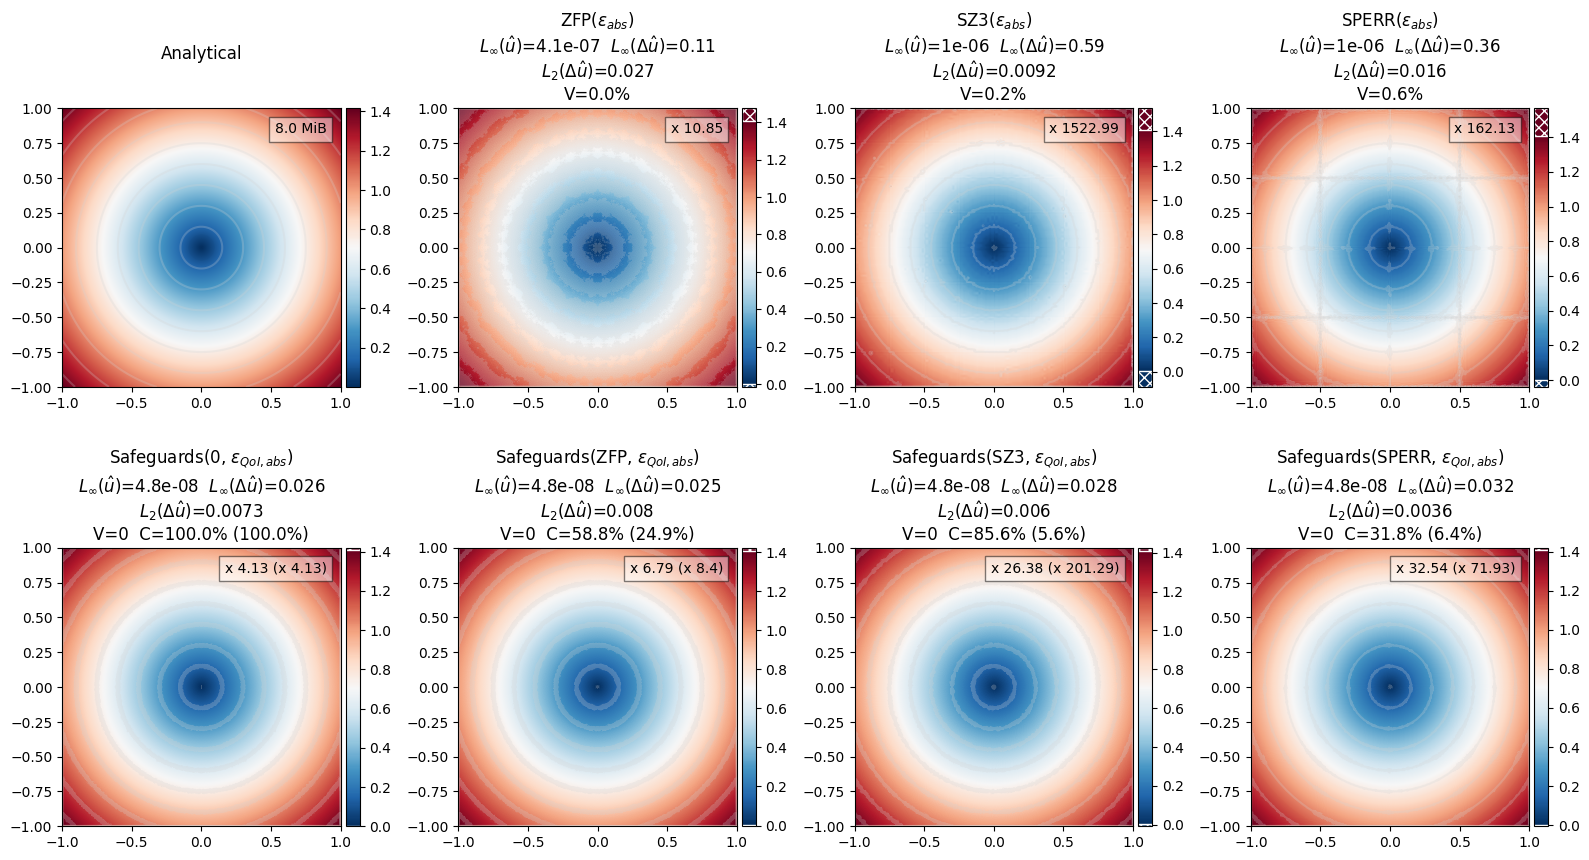

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

plot_DU(U, 1.0, axs[0, 0], "Analytical", DU_eb_abs=DU_eb_abs, my_DU=DU)
plot_DU(U_zfp, U_zfp_cr, axs[0, 1], r"ZFP($\epsilon_{abs}$)", DU_eb_abs=DU_eb_abs)
plot_DU(U_sz3, U_sz3_cr, axs[0, 2], r"SZ3($\epsilon_{abs}$)", DU_eb_abs=DU_eb_abs)
plot_DU(U_sperr, U_sperr_cr, axs[0, 3], r"SPERR($\epsilon_{abs}$)", DU_eb_abs=DU_eb_abs)

plot_DU(
    U_sg_qoi["zero"],
    U_sg_qoi_cr["zero"],
    axs[1, 0],
    r"Safeguards(0, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_zero,
    my_U_it=U_sg_it_qoi["zero"],
    cr_it=U_sg_it_qoi_cr["zero"],
)
plot_DU(
    U_sg_qoi["zfp.rs"],
    U_sg_qoi_cr["zfp.rs"],
    axs[1, 1],
    r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_zfp,
    my_U_it=U_sg_it_qoi["zfp.rs"],
    cr_it=U_sg_it_qoi_cr["zfp.rs"],
)
plot_DU(
    U_sg_qoi["sz3.rs"],
    U_sg_qoi_cr["sz3.rs"],
    axs[1, 2],
    r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_sz3,
    my_U_it=U_sg_it_qoi["sz3.rs"],
    cr_it=U_sg_it_qoi_cr["sz3.rs"],
)
plot_DU(
    U_sg_qoi["sperr.rs"],
    U_sg_qoi_cr["sperr.rs"],
    axs[1, 3],
    r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=DU_eb_abs,
    corr=U_sperr,
    my_U_it=U_sg_it_qoi["sperr.rs"],
    cr_it=U_sg_it_qoi_cr["sperr.rs"],
)

plt.tight_layout()

plt.savefig("derivative-radial.pdf", dpi=300)

plt.show()

## Example 2: $u(x, y) = e^{4 x + 3 y}$

The Laplacian of $u$ is $\Delta u = 25 u$.

We plot the natural logarithm of the Laplacian.

In [20]:
U = np.exp(4 * X + 3 * Y)

In [21]:
# analytical solution on uncompressed
DU = U * 25

In [22]:
# absolute error bound for error-bounded lossy compression
eb_abs = 1e-2

In [23]:
# compressed with ZFP
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

U_zfp_enc = zfp.encode(U)
U_zfp = zfp.decode(U_zfp_enc)
U_zfp_cr = U.nbytes / U_zfp_enc.nbytes

In [24]:
# compressed with SZ3
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

U_sz3_enc = sz3.encode(U)
U_sz3 = sz3.decode(U_sz3_enc)
U_sz3_cr = U.nbytes / U_sz3_enc.nbytes

In [25]:
# compressed with SPERR
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

U_sperr_enc = sperr.encode(U)
U_sperr = sperr.decode(U_sperr_enc)
U_sperr_cr = U.nbytes / U_sperr_enc.nbytes

In [26]:
# compressed to constant zero
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

U_zero_enc = zero.encode(U)
U_zero = zero.decode(U_zero_enc)

In [27]:
ln_DU_eb_abs = 1.0

In [28]:
U_sg_qoi = dict()
U_sg_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the log of the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_qoi = SafeguardsCodec(
        codec=codec,
        # numpy.gradient uses central differences on the inner points and
        #  forward/backward differences on the boundary
        # with arbitrary grid-based spacing and an edge boundary, the central
        #  finite differences on the boundary will be invalid, since the
        #  edge-extended point has the same coordinate as the edge, which the
        #  safeguards exploit to allow any inputs that still produce an invalid
        #  value
        # for arbitrary grid-based spacing, we therefore have to replicate
        #  numpy.gradient more closely and additionally safeguards forward/
        #  backward differences, with the valid boundary condition, that apply
        #  on the boundary
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=1, after=1, boundary="valid"),
                    dict(axis=1, before=1, after=1, boundary="valid"),
                ],
                type="abs",
                eb=ln_DU_eb_abs,
            ),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=1, type=-1, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=1, type=-1, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=2, after=0, boundary="valid"),
                    dict(axis=1, before=2, after=0, boundary="valid"),
                ],
                type="abs",
                eb=ln_DU_eb_abs,
            ),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=1, type=+1, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=1, type=+1, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=0, after=2, boundary="valid"),
                    dict(axis=1, before=0, after=2, boundary="valid"),
                ],
                type="abs",
                eb=ln_DU_eb_abs,
            ),
        ],
        fixed_constants=dict(X=X, Y=Y),
    )

    U_sg_qoi_enc = codec_sg_qoi.encode(U)
    U_sg_qoi[codec.codec_id] = codec_sg_qoi.decode(U_sg_qoi_enc)
    U_sg_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_qoi_enc).nbytes

In [29]:
U_sg_it_qoi = dict()
U_sg_it_qoi_cr = dict()

# compressed with the safeguards with an absolute error bound over the log of the Laplacian
for codec in [zfp, sz3, sperr, zero]:
    codec_sg_it_qoi = SafeguardsCodec(
        codec=codec,
        # numpy.gradient uses central differences on the inner points and
        #  forward/backward differences on the boundary
        # with arbitrary grid-based spacing and an edge boundary, the central
        #  finite differences on the boundary will be invalid, since the
        #  edge-extended point has the same coordinate as the edge, which the
        #  safeguards exploit to allow any inputs that still produce an invalid
        #  value
        # for arbitrary grid-based spacing, we therefore have to replicate
        #  numpy.gradient more closely and additionally safeguards forward/
        #  backward differences, with the valid boundary condition, that apply
        #  on the boundary
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=2, type=0, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=2, type=0, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=1, after=1, boundary="valid"),
                    dict(axis=1, before=1, after=1, boundary="valid"),
                ],
                type="abs",
                eb=ln_DU_eb_abs,
            ),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=1, type=-1, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=1, type=-1, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=2, after=0, boundary="valid"),
                    dict(axis=1, before=2, after=0, boundary="valid"),
                ],
                type="abs",
                eb=ln_DU_eb_abs,
            ),
            dict(
                kind="qoi_eb_stencil",
                qoi="""
                ln(
                    finite_difference(x, order=2, accuracy=1, type=+1, axis=0, grid_centre=c["Y"]) +
                    finite_difference(x, order=2, accuracy=1, type=+1, axis=1, grid_centre=c["X"])
                )
                """,
                neighbourhood=[
                    dict(axis=0, before=0, after=2, boundary="valid"),
                    dict(axis=1, before=0, after=2, boundary="valid"),
                ],
                type="abs",
                eb=ln_DU_eb_abs,
            ),
        ],
        fixed_constants=dict(X=X, Y=Y),
        # use iteration to refine the corrections
        compute=dict(unstable_iterative=True),
    )

    U_sg_it_qoi_enc = codec_sg_it_qoi.encode(U)
    U_sg_it_qoi[codec.codec_id] = codec_sg_it_qoi.decode(U_sg_it_qoi_enc)
    U_sg_it_qoi_cr[codec.codec_id] = U.nbytes / np.asarray(U_sg_it_qoi_enc).nbytes

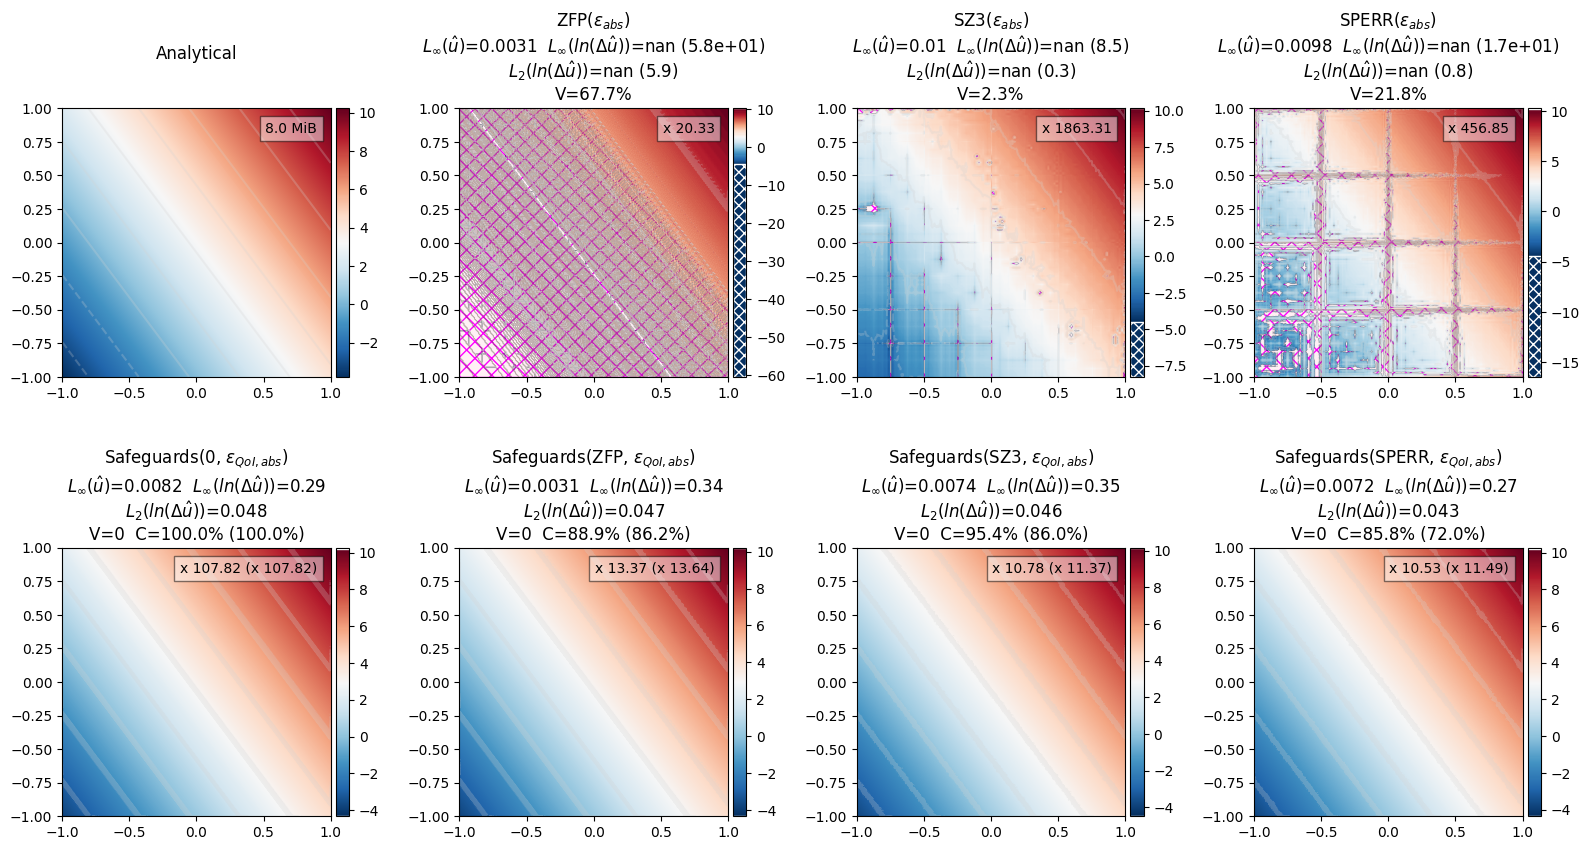

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

plot_DU(
    U,
    1.0,
    axs[0, 0],
    "Analytical",
    DU_eb_abs=ln_DU_eb_abs,
    my_DU=DU,
    transform=np.log,
    transform_symbol="ln",
)
plot_DU(
    U_zfp,
    U_zfp_cr,
    axs[0, 1],
    r"ZFP($\epsilon_{abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
)
plot_DU(
    U_sz3,
    U_sz3_cr,
    axs[0, 2],
    r"SZ3($\epsilon_{abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
)
plot_DU(
    U_sperr,
    U_sperr_cr,
    axs[0, 3],
    r"SPERR($\epsilon_{abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
)

plot_DU(
    U_sg_qoi["zero"],
    U_sg_qoi_cr["zero"],
    axs[1, 0],
    r"Safeguards(0, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
    corr=U_zero,
    my_U_it=U_sg_it_qoi["zero"],
    cr_it=U_sg_it_qoi_cr["zero"],
)
plot_DU(
    U_sg_qoi["zfp.rs"],
    U_sg_qoi_cr["zfp.rs"],
    axs[1, 1],
    r"Safeguards(ZFP, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
    corr=U_zfp,
    my_U_it=U_sg_it_qoi["zfp.rs"],
    cr_it=U_sg_it_qoi_cr["zfp.rs"],
)
plot_DU(
    U_sg_qoi["sz3.rs"],
    U_sg_qoi_cr["sz3.rs"],
    axs[1, 2],
    r"Safeguards(SZ3, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
    corr=U_sz3,
    my_U_it=U_sg_it_qoi["sz3.rs"],
    cr_it=U_sg_it_qoi_cr["sz3.rs"],
)
plot_DU(
    U_sg_qoi["sperr.rs"],
    U_sg_qoi_cr["sperr.rs"],
    axs[1, 3],
    r"Safeguards(SPERR, $\epsilon_{QoI,abs}$)",
    DU_eb_abs=ln_DU_eb_abs,
    transform=np.log,
    transform_symbol="ln",
    corr=U_sperr,
    my_U_it=U_sg_it_qoi["sperr.rs"],
    cr_it=U_sg_it_qoi_cr["sperr.rs"],
)

plt.tight_layout()

plt.savefig("derivative-log-exp.pdf", dpi=300)

plt.show()